In [3]:
import os
import json
import statistics
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from pathlib import Path
from sentence_transformers import SentenceTransformer
from sentence_aligner.pl_modules.pl_module import MyLightningModule
from sentence_aligner.pl_modules.pl_module_old import MyLightningModuleOld
from nn_core.serialization import load_model

In [4]:
device = "cuda"
model = load_model(module_class=MyLightningModuleOld, checkpoint_path=Path("/mnt/data/neural-sentence-aligner/storage/sentence_aligner/k5v3l9e3/checkpoints/epoch=270-step=4884326.ckpt.zip"), map_location=device).to(device).eval()
model.precomputed_embeddings = False
sentence_encoder = model.transformer

2022-12-16 08:14:40 INFO     Created a temporary directory at              ]8;id=540832;file:///mnt/data/envs/neural-sentence-aligner/lib/python3.9/site-packages/torch/distributed/nn/jit/instantiator.py\torch.distributed.nn.jit.instantiator]8;;\:]8;id=120395;file:///mnt/data/envs/neural-sentence-aligner/lib/python3.9/site-packages/torch/distributed/nn/jit/instantiator.py#21\21]8;;\
                             /tmp/tmp5qdlny1j                                                                      

                    INFO     Writing                                       ]8;id=921281;file:///mnt/data/envs/neural-sentence-aligner/lib/python3.9/site-packages/torch/distributed/nn/jit/instantiator.py\torch.distributed.nn.jit.instantiator]8;;\:]8;id=317815;file:///mnt/data/envs/neural-sentence-aligner/lib/python3.9/site-packages/torch/distributed/nn/jit/instantiator.py#76\76]8;;\
                             /tmp/tmp5qdlny1j/_remote_module_non_scriptabl                                         
                             e.py                                                                                  

                    INFO     Load pretrained SentenceTransformer:      ]8;id=922363;file:///mnt/data/envs/neural-sentence-aligner/lib/python3.9/site-packages/sentence_transformers/SentenceTransformer.py\sentence_transformers.SentenceTransformer]8;;\:]8;id=823348;file:///mnt/data/envs/neural-sentence-aligner/lib/python3.9/site-packages/sentence_transformers/SentenceTransformer.py#66\66]8;;\
                             sentence-transformers/LaBSE                                                           

2022-12-16 08:14:43 INFO     Use pytorch device: cuda                 ]8;id=67188;file:///mnt/data/envs/neural-sentence-aligner/lib/python3.9/site-packages/sentence_transformers/SentenceTransformer.py\sentence_transformers.SentenceTransformer]8;;\:]8;id=423823;file:///mnt/data/envs/neural-sentence-aligner/lib/python3.9/site-packages/sentence_transformers/SentenceTransformer.py#105\105]8;;\

In [5]:
transformer_name = "sentence-transformers/LaBSE"
labse = SentenceTransformer(transformer_name)

2022-12-16 08:15:16 INFO     Load pretrained SentenceTransformer:      ]8;id=843420;file:///mnt/data/envs/neural-sentence-aligner/lib/python3.9/site-packages/sentence_transformers/SentenceTransformer.py\sentence_transformers.SentenceTransformer]8;;\:]8;id=497128;file:///mnt/data/envs/neural-sentence-aligner/lib/python3.9/site-packages/sentence_transformers/SentenceTransformer.py#66\66]8;;\
                             sentence-transformers/LaBSE                                                           

2022-12-16 08:15:19 INFO     Use pytorch device: cuda                 ]8;id=134209;file:///mnt/data/envs/neural-sentence-aligner/lib/python3.9/site-packages/sentence_transformers/SentenceTransformer.py\sentence_transformers.SentenceTransformer]8;;\:]8;id=57423;file:///mnt/data/envs/neural-sentence-aligner/lib/python3.9/site-packages/sentence_transformers/SentenceTransformer.py#105\105]8;;\

In [ ]:
dataset = open("/mnt/data/neural-sentence-aligner/data/opus/books/train/train_CA-DE-Twain_Mark-Tom_Sawyer.jsonl", "r")
cosine_similarity = nn.CosineSimilarity(dim=0, eps=1e-6)
for line in dataset:
    example = json.loads(line)
    for s, semb in zip (example["targets"]["text"], example["targets"]["embs"]):
        model_emb = torch.tensor(sentence_encoder.encode(s))
        labse_emb = torch.tensor(labse.encode(s))
        file_emb = torch.tensor(semb)
        cs1 = cosine_similarity(model_emb, labse_emb)
        cs2 = cosine_similarity(model_emb, file_emb)
        cs3 = cosine_similarity(labse_emb, file_emb)
        print(cs1, cs2, cs3)

In [2]:
len(os.listdir("/mnt/data/neural-sentence-aligner/data-without-low-resource/opus/books/train"))

197

In [2]:
encoder = SentenceTransformer("sentence-transformers/LaBSE").to("cuda")

In [ ]:
file = open("/mnt/data/neural-sentence-aligner/data-without-low-resource/opus/books/train/train_EN-FR-Stendhal-Chartreuse_de_Parme.jsonl", "r")
cosine_similarity = nn.CosineSimilarity(dim=0, eps=1e-6)
for line in file:
    example = json.loads(line)
    source_sents = example["sources"]["text"]
    source_embs = example["sources"]["embs"]
    target_sents = example["targets"]["text"]
    target_embs = example["targets"]["embs"]
    for s, se in zip(source_sents, source_embs):
        cs = cosine_similarity(torch.tensor(encoder.encode(s)), torch.tensor(se))
        print(cs)
    for t, te in zip(target_sents, target_embs):
        cs = cosine_similarity(torch.tensor(encoder.encode(t)), torch.tensor(te))
        print(cs)

In [8]:
class DatasetStats():

    def __init__(self, dataset_dir):
        self.dataset_dir = dataset_dir
        self.new_dataset = []
    
    def compute_stats(self):
        prct_empty_source = []
        prct_empty_target = []
        for filename in os.listdir(self.dataset_dir):
            source_file_len = 0
            target_file_len = 0
            num_empty_sources = 0
            num_empty_targets = 0
            file = open(self.dataset_dir + filename, "r")
            for line in file:
                example = json.loads(line)
                for sid in example["sources"]["ids"]:
                    if sid == '':
                        num_empty_sources += 1
                    else:
                        source_file_len += 1
                for tid in example["targets"]["ids"]:
                    if tid == '':
                        num_empty_targets += 1
                    else:
                        target_file_len += 1
            source_empty_prct = round((num_empty_sources/source_file_len)*100, 3)
            target_empty_prct = round((num_empty_targets/target_file_len)*100, 3)
            prct_empty_source.append(source_empty_prct)
            prct_empty_target.append(target_empty_prct)
            # Togliere il noise qui
            if source_empty_prct <= 5.0 and target_empty_prct <= 4.0:
                self.new_dataset.append(filename)
        return [prct_empty_source, prct_empty_target]

In [9]:
Ds_train = DatasetStats("/mnt/data/neural-sentence-aligner/data/opus/books/old-train/")
percentages_train = Ds_train.compute_stats()

In [7]:
Ds_test = DatasetStats("/mnt/data/neural-sentence-aligner/data/opus/books/old-test/")
percentages_test = Ds_test.compute_stats()

In [10]:
df_train = pd.DataFrame(list(zip(percentages_train[0], percentages_train[1])), columns =['source', 'target'])

In [9]:
df_test = pd.DataFrame(list(zip(percentages_test[0], percentages_test[1])), columns =['source', 'target'])

In [11]:
kmeans = KMeans(n_clusters= 4)
label_train = kmeans.fit_predict(df_train)

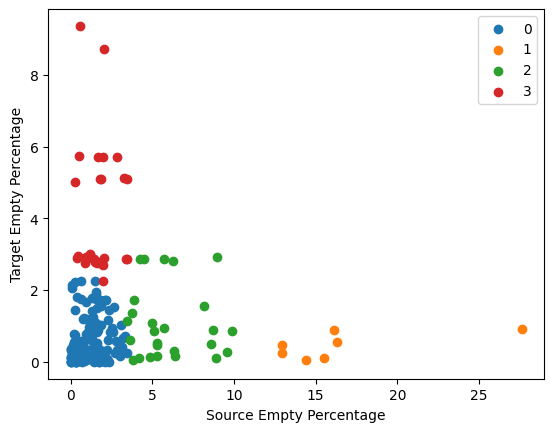

In [12]:
u_labels1 = np.unique(label_train)

for i in u_labels1:
    curr_df = df_train[label_train == i]
    plt.scatter(curr_df["source"] , curr_df["target"] , label = i)
plt.xlabel("Source Empty Percentage")
plt.ylabel("Target Empty Percentage")
plt.legend()
plt.show()

In [12]:
kmeans_test = KMeans(n_clusters= 4)
label_test = kmeans_test.fit_predict(df_test)

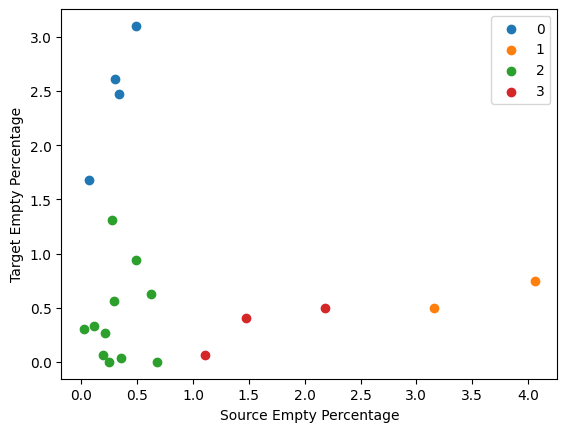

In [13]:
u_labels2 = np.unique(label_test)

for i in u_labels2:
    curr_df = df_test[label_test == i]
    plt.scatter(curr_df["source"], curr_df["target"] , label = i)
plt.xlabel("Source Empty Percentage")
plt.ylabel("Target Empty Percentage")
plt.legend()
plt.show()

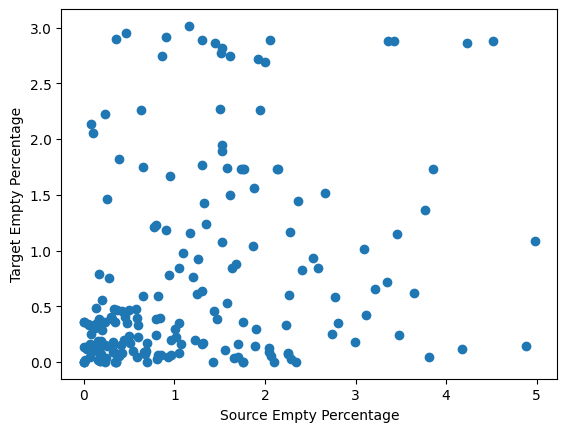

In [13]:
df_train_filtered = df_train[(df_train.source <= 5) & (df_train.target <= 4)]
plt.scatter(df_train_filtered["source"] , df_train_filtered["target"])
plt.xlabel("Source Empty Percentage")
plt.ylabel("Target Empty Percentage")
plt.show()

In [14]:
diff = list(set(os.listdir(Ds_train.dataset_dir)) - set(Ds_train.new_dataset))
len(diff)

34

In [15]:
len(Ds_train.new_dataset)

197

In [16]:
source = '/mnt/data/neural-sentence-aligner/data/opus/books/train'
destination = '/mnt/data/neural-sentence-aligner/data/opus/books/train-quarantine'

for f in diff:
    src_path = os.path.join(source, f)
    dst_path = os.path.join(destination, f)
    os.rename(src_path, dst_path)

In [25]:
len(os.listdir(source))

197

In [29]:
source = '/mnt/data/neural-sentence-aligner/data-without-low-resource/opus/books/train'
couples = Counter()
filename_without_low_resource = []
allowed_languages = ["EN", "DE", "ES", "FR", "HU", "NL", "IT"]
for filename in os.listdir(source):
    if filename[6:8] in allowed_languages and filename[9:11] in allowed_languages:
            filename_without_low_resource.append(filename)

diff = list(set(os.listdir(source)) - set(filename_without_low_resource))
diff

['train_HU-RU-Tolstoy_Leo-Anna_Karenina_vol2.jsonl',
 'train_FI-FR-Doyle_Arthur_Conan-Hound_of_the_Baskervilles.jsonl',
 'train_FR-PL-Doyle_Arthur_Conan-Hound_of_the_Baskervilles.jsonl',
 'train_HU-RU-Tolstoy_Leo-Anna_Karenina_vol1.jsonl',
 'train_EL-EN-Voltaire-Candide.jsonl',
 'train_CA-DE-Twain_Mark-Tom_Sawyer.jsonl',
 'train_DE-RU-Tolstoy_Leo-Anna_Karenina_vol2.jsonl',
 'train_IT-RU-Tolstoy_Leo-Anna_Karenina_vol2.jsonl',
 'train_ES-PT-Carroll_Lewis-Alice_in_wonderland.jsonl',
 'train_HU-PL-Doyle_Arthur_Conan-Hound_of_the_Baskervilles.jsonl',
 'train_IT-SV-Jerome_Jerome_K-Three_Men_in_a_Boat.jsonl',
 'train_ES-NO-Doyle_Arthur_Conan-Hound_of_the_Baskervilles.jsonl',
 'train_EN-PL-Doyle_Arthur_Conan-Hound_of_the_Baskervilles.jsonl',
 'train_CA-EN-Twain_Mark-Tom_Sawyer.jsonl',
 'train_DE-RU-Tolstoy_Leo-Anna_Karenina_vol1.jsonl',
 'train_FR-RU-Bulgakov_Mikhail-Master_and_Margarita.jsonl',
 'train_FR-PT-Carroll_Lewis-Alice_in_wonderland.jsonl',
 'train_EN-EO-Poe_Edgar_Allan-Fall_of_the_H

In [30]:
source = '/mnt/data/neural-sentence-aligner/data-without-low-resource/opus/books/train'
destination = '/mnt/data/neural-sentence-aligner/data-without-low-resource/opus/books/train-quarantine'

for f in diff:
    src_path = os.path.join(source, f)
    dst_path = os.path.join(destination, f)
    os.rename(src_path, dst_path)